In [ ]:
!pip install torch pandas numpy transformers matplotlib ipywidgets catboost scikit-learn shap seaborn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.2/91.2 kB 2.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.9/40.9 kB 8.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.5/40.5 kB 7.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.7/57.7 kB 6.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.9/106.9 kB 7.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.3/12.3 MB 41.9 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.8/10.8 MB 87.7 MB/s eta 0:00:00:00:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.6/8.6 MB 119.6 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 40.8 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.9/12.9 MB 76.8 MB/s eta 0:00:00:00:01:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 996.4/996.4 kB 71.8 MB/s eta 0:

In [ ]:
import gc
import torch

# PyTorch GPU 캐시 비우기
torch.cuda.empty_cache()

# Python 객체 참조 해제 및 가비지 컬렉션
gc.collect()

[E01][B000] loss=30.3671 | MAE=31.6315 | SMAPE=106.69% | 예측값: [13.618577    0.38936234 12.462345  ] | 실제값: [36. 46. 59.]
[E01][B010] loss=36.4364 | MAE=13.1830 | SMAPE=34.52% | 예측값: [30.68952  18.360106 34.86283 ] | 실제값: [26. 26. 34.]
[E01][B020] loss=18.2996 | MAE=41.6654 | SMAPE=58.77% | 예측값: [113.66124  77.27905 110.20952] | 실제값: [65. 42. 39.]
[E01][B030] loss=25.4055 | MAE=27.6299 | SMAPE=19.24% | 예측값: [163.22978 166.38579 143.93353] | 실제값: [145. 122. 120.]
[E01][B040] loss=37.7632 | MAE=37.1677 | SMAPE=16.53% | 예측값: [222.74884 271.09875 224.57169] | 실제값: [167. 166. 165.]
[E01][B050] loss=22.7112 | MAE=8.8237 | SMAPE=25.90% | 예측값: [23.54189  21.47714  30.399427] | 실제값: [34. 36. 28.]
[E01][B060] loss=33.6166 | MAE=18.1928 | SMAPE=35.52% | 예측값: [63.292446 75.24423  49.040863] | 실제값: [49. 82. 33.]
[E01][B070] loss=32.9766 | MAE=22.8110 | SMAPE=14.72% | 예측값: [201.29614 174.5759  165.5762 ] | 실제값: [154. 153. 160.]
[E01][B080] loss=17.8764 | MAE=26.5556 | SMAPE=17.08% | 예측값: [184.65437 1

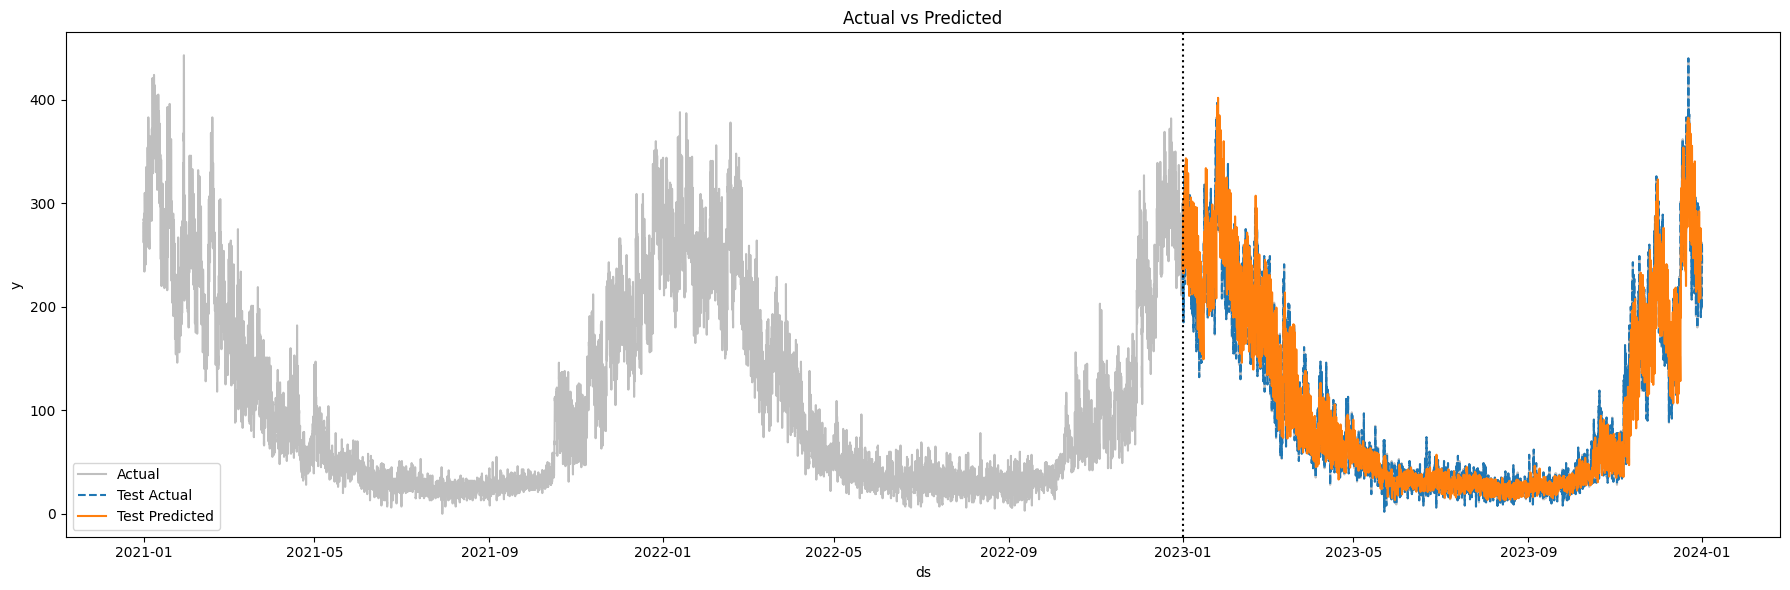

In [2]:
import math
import time
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split
from torch.cuda.amp import autocast, GradScaler
from transformers import AutoConfig, AutoModel, AutoTokenizer
import matplotlib.pyplot as plt

# -----------------------------
# (1) Dataset (y값만 사용)
# -----------------------------
class TimeSeriesDataset(Dataset):
    def __init__(self, df, seq_len, pred_len, target_col="y"):
        self.seq_len   = seq_len
        self.pred_len  = pred_len
        self.target_col= target_col
        self.df        = df.reset_index(drop=True)
        self.features  = []  # 파생변수 없이 y만 사용
        self.data      = df[[target_col]].values.astype(np.float32)
        self.targets   = df[target_col].values.astype(np.float32)

    def __len__(self):
        return len(self.df) - self.seq_len - self.pred_len + 1

    def __getitem__(self, idx):
        x_enc   = self.data[idx : idx + self.seq_len]
        y_label = self.targets[idx + self.seq_len : idx + self.seq_len + self.pred_len]
        return (
            torch.tensor(x_enc),                # [seq_len, 1]
            torch.tensor([]),                   # dummy
            torch.tensor(y_label).unsqueeze(-1) # [pred_len, 1]
        )

# -----------------------------
# (2) RevIN
# -----------------------------
class RevIN(nn.Module):
    def __init__(self, num_features, affine=True, eps=1e-5):
        super().__init__()
        self.affine = affine
        self.eps    = eps
        if affine:
            self.gamma = nn.Parameter(torch.ones(1,1,num_features))
            self.beta  = nn.Parameter(torch.zeros(1,1,num_features))

    def forward(self, x, mode):
        if mode == "norm":
            m = x.mean(dim=1, keepdim=True)
            s = x.std(dim=1, keepdim=True)
            xn = (x - m) / (s + self.eps)
            if self.affine:
                xn = xn * self.gamma + self.beta
            return xn, m, s
        elif mode == "denorm":
            xn, m, s = x
            if self.affine:
                xn = (xn - self.beta) / (self.gamma + self.eps)
            return xn * (s + self.eps) + m
        else:
            raise ValueError("mode must be 'norm' or 'denorm'")

# -----------------------------
# (3) PatchEmbedding
# -----------------------------
class PatchEmbedding(nn.Module):
    def __init__(self, d_model, patch_len, stride, dropout=0.1):
        super().__init__()
        self.patch_len = patch_len
        self.stride    = stride
        self.token_emb = nn.Linear(patch_len, d_model)
        self.dropout   = nn.Dropout(dropout)

    def forward(self, x):
        B, T, F = x.shape
        Lp, S   = self.patch_len, self.stride
        num_patches = math.floor((T - Lp) / S) + 2
        total_len   = (num_patches - 1) * S + Lp
        pad = total_len - T
        if pad > 0:
            x = nn.functional.pad(x, (0,0,0,pad), mode="replicate")
        x = x.permute(0,2,1)                                    # [B, F, T]
        xu = x.unfold(2, Lp, S).contiguous().view(B*F, num_patches, Lp)
        pe = self.token_emb(xu).view(B, F * num_patches, -1)   # [B, F*num_patches, d_model]
        return self.dropout(pe), F, num_patches

# -----------------------------
# (4) ReprogrammingLayer
# -----------------------------
class ReprogrammingLayer(nn.Module):
    def __init__(self, d_model, n_heads, d_keys=None, d_llm=None, dropout=0.1):
        super().__init__()
        d_keys = d_keys or (d_model // n_heads)
        self.n_heads = n_heads
        self.query_proj = nn.Linear(d_model, d_keys * n_heads)
        self.key_proj   = nn.Linear(d_llm,   d_keys * n_heads)
        self.value_proj = nn.Linear(d_llm,   d_keys * n_heads)
        self.out_proj   = nn.Linear(d_keys * n_heads, d_llm)
        self.dropout    = nn.Dropout(dropout)

    def forward(self, tgt, src, val):
        B, L, _ = tgt.shape
        S, _    = src.shape
        H       = self.n_heads
        E       = int(tgt.size(-1) // H)

        Q = self.query_proj(tgt).view(B, L, H, E)    # [B, L, H, E]
        K = self.key_proj(src).view(S, H, E)         # [S, H, E]
        V = self.value_proj(val).view(S, H, E)       # [S, H, E]

        scores = torch.einsum("blhe,she->bhls", Q, K) / math.sqrt(E)
        attn   = torch.softmax(scores, dim=-1)
        attn   = self.dropout(attn)
        out    = torch.einsum("bhls,she->blhe", attn, V).reshape(B, L, H*E)
        return self.out_proj(out)

# -----------------------------
# (5) FlattenHead
# -----------------------------
class FlattenHead(nn.Module):
    def __init__(self, n_vars, num_patches, d_llm, pred_len, dropout=0.1):
        super().__init__()
        in_feats  = n_vars * num_patches * d_llm
        out_feats = pred_len * 1
        self.flatten = nn.Flatten(start_dim=1)
        self.linear  = nn.Linear(in_feats, out_feats)
        self.dropout = nn.Dropout(dropout)
        self.pred_len= pred_len

    def forward(self, x):
        B = x.size(0)
        x = self.flatten(x)
        x = self.linear(x)
        x = self.dropout(x)
        return x.view(B, self.pred_len, 1)

# -----------------------------
# (6) TimeLLMMulti
# -----------------------------
class TimeLLMMulti(nn.Module):
    def __init__(
        self, seq_len, pred_len, enc_in,
        d_model=768, d_ff=768, patch_len=48, stride=24,
        llm_layers=6, n_heads=12, dropout=0.1, prompt_maxlen=1024,
        num_prototypes=256
    ):
        super().__init__()
        self.seq_len = seq_len
        self.pred_len= pred_len
        self.enc_in  = enc_in
        self.prompt_maxlen = prompt_maxlen

        # 1) Frozen LLM backbone
        cfg = AutoConfig.from_pretrained(
            "distilgpt2",
            n_embd   = d_ff,
            n_layer  = llm_layers,
            n_head   = n_heads,
            output_hidden_states=False,
            output_attentions=False,
            add_cross_attention=False
        )
        self.llm = AutoModel.from_pretrained("distilgpt2", config=cfg)
        for p in self.llm.parameters():
            p.requires_grad = False
        self.tokenizer = AutoTokenizer.from_pretrained("distilgpt2", use_fast=True)
        self.tokenizer.pad_token = self.tokenizer.eos_token

        # 2) RevIN
        self.revin_in  = RevIN(enc_in)
        self.revin_out = RevIN(enc_in)

        # 3) PatchEmbedding + projection
        self.patch_embed = PatchEmbedding(d_model, patch_len, stride, dropout)
        self.proj_pe     = nn.Linear(d_model, d_ff) if d_model != d_ff else nn.Identity()

        # 4) Text prototypes
        W = self.llm.get_input_embeddings().weight  # [vocab_size, d_ff]
        vocab_size = W.size(0)
        self.mapping_layer = nn.Linear(vocab_size, num_prototypes, bias=False)
        self.prototype_emb = nn.Parameter(self.mapping_layer.weight @ W.detach())

        # 5) Reprogramming
        self.reprog = ReprogrammingLayer(d_model=d_ff, n_heads=n_heads, d_llm=d_ff, dropout=dropout)

        # 6) Prediction head
        max_patches = math.floor((seq_len - patch_len) / stride) + 2
        self.head = FlattenHead(n_vars=enc_in, num_patches=max_patches, d_llm=d_ff, pred_len=pred_len, dropout=dropout)

    def forward(self, x_enc, prompt: str = None):
        B = x_enc.size(0)

        # a) RevIN normalization
        x_norm, mean, std = self.revin_in(x_enc, "norm")

        # b) Patch embedding + projection
        pe, F, num_p = self.patch_embed(x_norm)       # [B, F*num_p, d_model]
        pe = self.proj_pe(pe)                         # [B, F*num_p, d_ff]

        # c) Reprogramming with prototypes
        rep = self.reprog(pe, self.prototype_emb, self.prototype_emb)  # [B, F*num_p, d_ff]

        # d) Prompt embedding
        prompts = [prompt or ""] * B
        ids = self.tokenizer(prompts, padding=True, truncation=True,
                             max_length=self.prompt_maxlen,
                             return_tensors="pt").input_ids.to(x_enc.device)
        p_emb = self.llm.get_input_embeddings()(ids)  # [B, Lp, d_ff]

        # e) Concat and LLM forward
        inp = torch.cat([p_emb, rep], dim=1)          # [B, Lp + F*num_p, d_ff]
        llm_out = self.llm(inputs_embeds=inp).last_hidden_state
        rep_out = llm_out[:, -rep.size(1):, :]        # [B, F*num_p, d_ff]

        # f) Prediction head
        pred = self.head(rep_out)                     # [B, pred_len, 1]

        # g) Denormalize & slice single channel (y only)
        out_all = self.revin_out((pred, mean, std), "denorm")  # [B, pred_len, enc_in]
        out     = out_all[..., 0].unsqueeze(-1)                # [B, pred_len, 1]
        return out

# -----------------------------
# Metrics
# -----------------------------
def calc_metrics(true, pred):
    rmse  = np.sqrt(np.mean((true - pred) ** 2))
    mae   = np.mean(np.abs(true - pred))
    mape  = np.mean(np.abs((true - pred) / (true + 1e-8))) * 100
    smape = 100 * np.mean(2 * np.abs(pred - true) / (np.abs(true) + np.abs(pred) + 1e-8))
    return rmse, mae, mape, smape

# -----------------------------
# Training & Inference
# -----------------------------
if __name__ == "__main__":
    # Load & preprocess
    df = pd.read_csv("A지사_train.csv")
    df["ds"] = pd.to_datetime(df["ds"])
    df = df.rename(columns={
        "TA":"Temperature","WD":"WindDirection","WS":"WindSpeed",
        "RN_DAY":"DailyPrecipitation","RN_HR1":"HourlyPrecipitation",
        "HM":"Humidity","SI":"SolarIrradiance","ta_chi":"ApparentTemperature"
    })
    train_df = df[df["ds"].dt.year.isin([2021,2022])].reset_index(drop=True)
    test_df  = df[df["ds"].dt.year==2023].reset_index(drop=True)

    seq_len, pred_len = 24*7, 24*1
    batch_size, val_ratio = 4, 0.2

    ds      = TimeSeriesDataset(train_df, seq_len, pred_len, "y")
    n_val   = int(len(ds) * val_ratio)
    n_train = len(ds) - n_val
    train_ds, val_ds = random_split(ds, [n_train, n_val])
    tr_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, drop_last=True)
    va_loader = DataLoader(val_ds,   batch_size=batch_size, shuffle=False, drop_last=False)

    feature_names = ["y"]  # y만 사용

    # Auto-generate English prompt (y만 사용)
    feature_importance_str = "y is the only feature used for predicting y."
    corr_str = "y: corr=1.00"
    stats = train_df[["y"]].describe().T
    stats_str = "\n".join([f"y: mean={r['mean']:.2f}, std={r['std']:.2f}, min={r['min']:.2f}, max={r['max']:.2f}" for _,r in stats.iterrows()])
    y_s = train_df["y"].describe()
    target_stats_str = f"mean={y_s['mean']:.2f}, std={y_s['std']:.2f}, min={y_s['min']:.2f}, max={y_s['max']:.2f}, skewness={train_df['y'].skew():.2f}, kurtosis={train_df['y'].kurt():.2f}"
    Q1, Q3 = train_df["y"].quantile(0.25), train_df["y"].quantile(0.75)
    outlier_str = f"Target outlier ratio: {((train_df['y']<Q1-1.5*(Q3-Q1))|(train_df['y']>Q3+1.5*(Q3-Q1))).mean()*100:.2f}%"
    pap_prompt = f"""
[feature_importance]
{feature_importance_str}

[correlation_with_target]
{corr_str}

[feature_statistics]
{stats_str}

[target_statistics]
{target_stats_str}
{outlier_str}

[instruction]
Using only the past values of y, predict future values of y.
"""

    # Model, optimizer, scheduler, criterion
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = TimeLLMMulti(seq_len, pred_len, 1).to(device)
    optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-4)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode="min", patience=2, factor=0.5)
    criterion = nn.L1Loss()
    scaler    = GradScaler()

    best_val, patience, counter = float("inf"), 3, 0
    epochs = 50

    # Training loop
    for epoch in range(1, epochs+1):
        model.train()
        train_loss = 0.0
        for i, (x, _, y) in enumerate(tr_loader):
            x, y = x.to(device), y.to(device)
            optimizer.zero_grad()
            with autocast():
                o = model(x, prompt=pap_prompt)
                if o.shape != y.shape:
                    o = o[..., 0:1]
                loss = criterion(o, y)
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
            train_loss += loss.item()
            if i % 10 == 0:
                pred_np = o[0, :, 0].detach().cpu().numpy()
                true_np = y[0, :, 0].detach().cpu().numpy()
                _, mae, _, smape = calc_metrics(true_np, pred_np)
                print(f"[E{epoch:02d}][B{i:03d}] loss={loss.item():.4f} | MAE={mae:.4f} | SMAPE={smape:.2f}% | 예측값: {pred_np[:3]} | 실제값: {true_np[:3]}")
        # Validation
        model.eval()
        val_loss, val_mae, val_sm = 0.0, 0.0, 0.0
        with torch.no_grad():
            for x, _, y in va_loader:
                x, y = x.to(device), y.to(device)
                o = model(x, prompt=pap_prompt)
                if o.shape != y.shape:
                    o = o[..., 0:1]
                val_loss += criterion(o, y).item()
                _, mae, _, sm = calc_metrics(y.cpu().numpy().flatten(), o.cpu().numpy().flatten())
                val_mae += mae
                val_sm  += sm
        val_loss /= len(va_loader)
        val_mae  /= len(va_loader)
        val_sm   /= len(va_loader)
        print(f"Epoch {epoch:02d}| train {train_loss:.4f}| val {val_loss:.4f}| MAE {val_mae:.4f}| SMAPE {val_sm:.2f}%")

        scheduler.step(val_loss)
        if val_loss < best_val:
            best_val, counter = val_loss, 0
            torch.save(model.state_dict(), "best_timellm_y.pt")
        else:
            counter += 1
            if counter >= patience:
                print("Early stopping.")
                break

    # Testing
    model.load_state_dict(torch.load("best_timellm_y.pt"))
    model.eval()
    test_in  = pd.concat([train_df.tail(seq_len), test_df], ignore_index=True)
    test_ds  = TimeSeriesDataset(test_in, seq_len, pred_len, "y")
    preds    = np.full(len(test_df), np.nan)
    start_t  = time.time()
    with torch.no_grad():
        for idx in range(0, len(test_ds), pred_len):
            x, _, _ = test_ds[idx]
            x = x.unsqueeze(0).to(device)
            y_hat = model(x, prompt=pap_prompt)[0,:,0].cpu().numpy()
            end = min(idx + pred_len, len(test_df))
            preds[idx:end] = y_hat[: end-idx]
    elapsed = time.time() - start_t

    rmse, mae, mape, smape = calc_metrics(test_df["y"].values, preds)
    print(f"Test RMSE: {rmse:.4f}")
    print(f"Test MAE : {mae:.4f}")
    print(f"Test MAPE: {mape:.2f}%")
    print(f"Test SMAPE: {smape:.2f}%")
    print(f"Inference time: {elapsed:.2f}s")

    # Plot results
    df_all = pd.concat([train_df, test_df], ignore_index=True)
    df_plot= pd.DataFrame({"ds": test_df["ds"], "true": test_df["y"], "pred": preds})
    plt.figure(figsize=(18,6))
    plt.plot(df_all["ds"], df_all["y"], label="Actual", color="gray", alpha=0.5)
    plt.plot(df_plot["ds"], df_plot["true"], label="Test Actual", linestyle="--")
    plt.plot(df_plot["ds"], df_plot["pred"], label="Test Predicted")
    plt.axvline(df_plot["ds"].iloc[0], color="black", linestyle=":")
    plt.xlabel("ds"); plt.ylabel("y"); plt.legend(); plt.title("Actual vs Predicted")
    plt.tight_layout(); plt.show()

In [19]:
# ...existing code...

print("===== 주요 파라미터 및 환경 정보 =====")
print(f"seq_len           : {seq_len}               # 입력 시계열 길이 (과거 입력 window)")
print(f"pred_len          : {pred_len}              # 예측 시계열 길이 (미래 예측 window)")
print(f"batch_size        : {batch_size}            # 학습 배치 크기")
print(f"val_ratio         : {val_ratio}             # 검증 데이터 비율")
print(f"train_df 길이     : {len(train_df)}         # 학습 데이터 샘플 수")
print(f"test_df 길이      : {len(test_df)}          # 테스트 데이터 샘플 수")
print(f"feature_names     : {feature_names if 'feature_names' in locals() else ['y']}  # 입력 특성(변수) 목록")
print(f"epochs            : {epochs}                # 최대 학습 epoch 수")
print(f"device            : {device}                # 사용 디바이스 (cpu/gpu)")
print(f"optimizer         : {type(optimizer).__name__}   # 최적화 알고리즘")
print(f"learning_rate     : {optimizer.param_groups[0]['lr']}   # 초기 학습률")
print(f"scheduler         : {type(scheduler).__name__}   # 러닝레이트 스케줄러")
print(f"criterion         : {type(criterion).__name__}   # 손실 함수")
print(f"scaler            : {type(scaler).__name__}      # AMP 스케일러 (fp16)")
print(f"model class       : {type(model).__name__}       # 모델 클래스명")
print(f"model param count : {sum(p.numel() for p in model.parameters())}   # 전체 파라미터 수")
print(f"model trainable   : {sum(p.numel() for p in model.parameters() if p.requires_grad)}   # 학습 가능한 파라미터 수")
print(f"patch_len         : {model.patch_embed.patch_len if hasattr(model, 'patch_embed') else 'N/A'}   # PatchEmbedding patch 길이")
print(f"stride            : {model.patch_embed.stride if hasattr(model, 'patch_embed') else 'N/A'}      # PatchEmbedding stride")
print(f"llm_layers        : {model.llm.config.n_layer if hasattr(model, 'llm') else 'N/A'}              # LLM 레이어 수")
print(f"n_heads           : {model.llm.config.n_head if hasattr(model, 'llm') else 'N/A'}               # LLM 헤드 수")
print(f"d_model           : {model.llm.config.n_embd if hasattr(model, 'llm') else 'N/A'}               # LLM 임베딩 차원")
print(f"prompt_maxlen     : {model.prompt_maxlen if hasattr(model, 'prompt_maxlen') else 'N/A'}         # 프롬프트 최대 길이")
print(f"num_prototypes    : {model.prototype_emb.shape[0] if hasattr(model, 'prototype_emb') else 'N/A'} # 텍스트 프로토타입 개수")
print("===============================")
# ...existing code...

===== 주요 파라미터 및 환경 정보 =====
seq_len           : 168               # 입력 시계열 길이 (과거 입력 window)
pred_len          : 24              # 예측 시계열 길이 (미래 예측 window)
batch_size        : 4            # 학습 배치 크기
val_ratio         : 0.2             # 검증 데이터 비율
train_df 길이     : 17518         # 학습 데이터 샘플 수
test_df 길이      : 8759          # 테스트 데이터 샘플 수
feature_names     : ['y']  # 입력 특성(변수) 목록
epochs            : 50                # 최대 학습 epoch 수
device            : cuda                # 사용 디바이스 (cpu/gpu)
optimizer         : Adam   # 최적화 알고리즘
learning_rate     : 5e-05   # 초기 학습률
scheduler         : ReduceLROnPlateau   # 러닝레이트 스케줄러
criterion         : L1Loss   # 손실 함수
scaler            : GradScaler      # AMP 스케일러 (fp16)
model class       : TimeLLMMulti       # 모델 클래스명
model param count : 97504028   # 전체 파라미터 수
model trainable   : 15591452   # 학습 가능한 파라미터 수
patch_len         : 48   # PatchEmbedding patch 길이
stride            : 24      # PatchEmbedding stride
llm_layers        : 6              # LLM 레

In [ ]:
# ...existing code...
preds = []
start_t = time.time()
with torch.no_grad():
    for idx in range(0, len(test_ds), pred_len):
        x, _, _ = test_ds[idx]
        x = x.unsqueeze(0).to(device)
        y_hat = model(x, prompt=pap_prompt)[0,:,0].cpu().numpy()
        preds.extend(y_hat.tolist())
preds = np.array(preds)[:len(test_df)]  # test_df 길이에 맞게 자르기
elapsed = time.time() - start_t
# ...existing code...

In [15]:
print("test_df 길이:", len(test_df))
print("preds 길이:", len(preds))

test_df 길이: 8759
preds 길이: 8736


Test RMSE: 17.6858
Test MAE : 11.9660
Test MAPE: 17.06%
Test SMAPE: 15.55%
Inference time: 6.43s


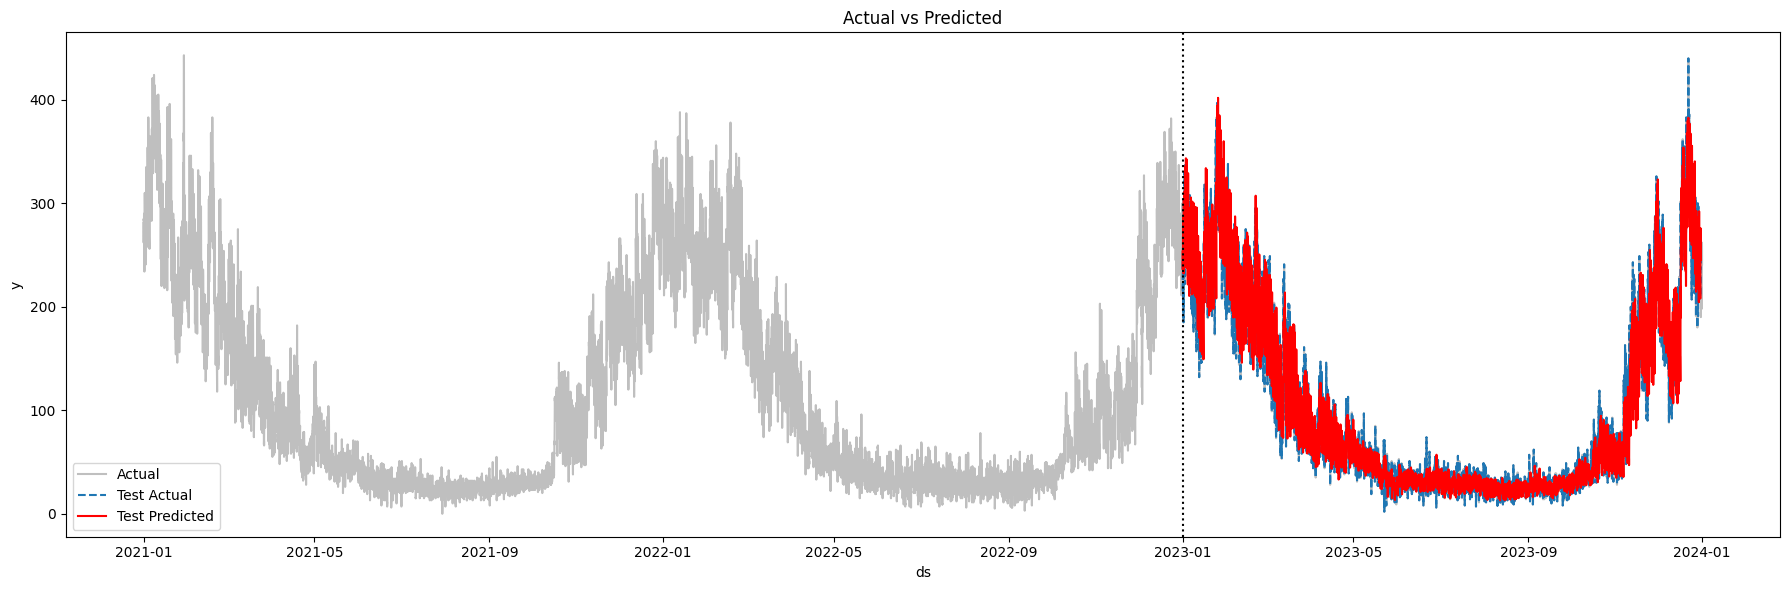

In [20]:
# ...existing code...

# preds 길이에 맞게 test_df도 잘라서 metric 계산
test_df_cut = test_df.iloc[:len(preds)].copy()

rmse, mae, mape, smape = calc_metrics(test_df_cut["y"].values, preds)
print(f"Test RMSE: {rmse:.4f}")
print(f"Test MAE : {mae:.4f}")
print(f"Test MAPE: {mape:.2f}%")
print(f"Test SMAPE: {smape:.2f}%")
print(f"Inference time: {elapsed:.2f}s")

# Plot results (예측선을 빨간색으로)
df_all = pd.concat([train_df, test_df], ignore_index=True)
df_plot= pd.DataFrame({"ds": test_df_cut["ds"], "true": test_df_cut["y"], "pred": preds})
plt.figure(figsize=(18,6))
plt.plot(df_all["ds"], df_all["y"], label="Actual", color="gray", alpha=0.5)
plt.plot(df_plot["ds"], df_plot["true"], label="Test Actual", linestyle="--")
plt.plot(df_plot["ds"], df_plot["pred"], label="Test Predicted", color="red")  # 빨간색으로 변경
plt.axvline(df_plot["ds"].iloc[0], color="black", linestyle=":")
plt.xlabel("ds"); plt.ylabel("y"); plt.legend(); plt.title("Actual vs Predicted")
plt.tight_layout(); plt.show()
# ...existing code...

In [4]:
preds

array([253.38529968, 239.50785828, 237.99656677, ...,          nan,
                nan,          nan])

In [9]:
# ...existing code...
preds = []
start_t = time.time()
with torch.no_grad():
    for idx in range(0, len(test_ds), pred_len):
        x, _, _ = test_ds[idx]
        x = x.unsqueeze(0).to(device)
        y_hat = model(x, prompt=pap_prompt)[0,:,0].cpu().numpy()
        preds.extend(y_hat.tolist())
preds = np.array(preds)[:len(test_df)]  # test_df 길이에 맞게 자르기
elapsed = time.time() - start_t
# ...existing code...

In [10]:
preds

array([253.38529968, 239.50785828, 237.99656677, ..., 270.74401855,
       256.85653687, 245.43377686])

In [13]:
# preds 배열에 결측치가 몇 개인지 확인
print("nan 개수:", np.isnan(preds).sum())
print("전체 길이:", len(preds))
print("nan 비율:", np.isnan(preds).mean())

nan 개수: 0
전체 길이: 8736
nan 비율: 0.0
